In [1]:
# Import required packages
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, InputLayer
from tensorflow.keras.utils import to_categorical

import os
import time
import warnings
warnings.filterwarnings('ignore')

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


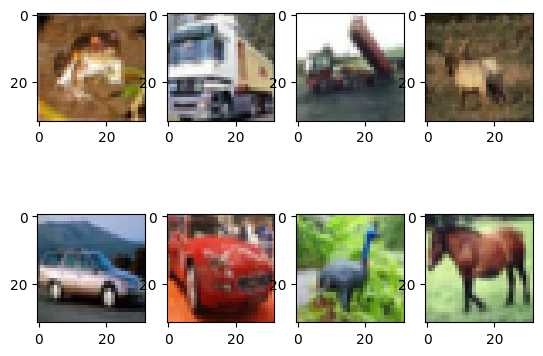

In [3]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [4]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [ ]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

# Model 1 - CNN

In [5]:
np.random.seed(5243_1)

# split the data into training and validation sets basing on the noisy labels and clean labels
imgs = imgs.astype('float32') /255.0

# Clean data
x_clean = imgs[0:10000]
y_clean = clean_labels

# Noisy data
x_noisy = imgs[10000:]
y_noisy = noisy_labels[10000:]

x_train_noisy, x_val_noisy, y_train_noisy, y_val_noisy = train_test_split(imgs[10000:], noisy_labels[10000:], test_size=0.2, random_state=42)

x_train_clean, x_val_clean, y_train_clean, y_val_clean = train_test_split(imgs[0:10000], clean_labels, test_size=0.2, random_state=42)

In [6]:
# Ensure reproducibility
np.random.seed(52433)

# Define the model architecture
label_correction_model = Sequential([
    InputLayer(input_shape=(32, 32, 3)),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    Dropout(0.3),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(momentum=0.9),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    Dropout(0.3),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    Dropout(0.3),
    Conv2D(filters=256, kernel_size=3, activation='relu'),
    BatchNormalization(momentum=0.9),
    Flatten(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

# Use the legacy RMSprop optimizer
optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=1e-3)

# Define the model checkpoint callback with a .keras extension
filepath = 'lcn_weights_best.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list_2 = [checkpoint]

# Compile the model
label_correction_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Start time
start_time = time.time()

# Fit the model (assuming x_train_clean, y_train_clean, x_val_clean, and y_val_clean are previously defined)
label_correction_model_history_callback = label_correction_model.fit(
    x_train_noisy, y_train_noisy, batch_size = 128, epochs=40, validation_data=(x_val_noisy, y_val_noisy), callbacks=callbacks_list_2
)

# End time
end_time = time.time()

# Calculate total time taken
total_time = end_time - start_time
print(f"Program executed in {total_time} seconds.")

2024-03-20 17:35:55.432464: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-20 17:35:55.432484: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-20 17:35:55.432488: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-20 17:35:55.432516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-20 17:35:55.432529: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/40


2024-03-20 17:35:55.959633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 2.6331 - accuracy: 0.1138
Epoch 1: val_accuracy improved from -inf to 0.10463, saving model to lcn_weights_best.keras
250/250 [==============================] - 4s 13ms/step - loss: 2.6331 - accuracy: 0.1138 - val_loss: 2.5199 - val_accuracy: 0.1046
Epoch 2/40
247/250 [============================>.] - ETA: 0s - loss: 2.4267 - accuracy: 0.1221
Epoch 2: val_accuracy did not improve from 0.10463
250/250 [==============================] - 3s 12ms/step - loss: 2.4262 - accuracy: 0.1223 - val_loss: 2.4122 - val_accuracy: 0.1010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 2.3863 - accuracy: 0.1260
Epoch 3: val_accuracy improved from 0.10463 to 0.11563, saving model to lcn_weights_best.keras
250/250 [==============================] - 3s 12ms/step - loss: 2.3863 - accuracy: 0.1260 - val_loss: 2.3747 - val_accuracy: 0.1156
Epoch 4/40
249/250 [============================>.] - ETA: 0s - loss: 2.3658 - accuracy: 

In [7]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, InputLayer
import tensorflow as tf

# Define the model architecture (this should match the architecture used to save the weights)
correct_model = Sequential([
    InputLayer(input_shape=(32, 32, 3)),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(momentum=0.9),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    Dropout(0.3),
    
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    Dropout(0.3),
    
    Conv2D(filters=256, kernel_size=3, activation='relu'),
    BatchNormalization(momentum=0.9),
    Flatten(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

# Load the weights
correct_model.load_weights('lcn_weights_best.keras')

# Compiling the model with 'adam' optimizer (or you can use the same optimizer as during training)
correct_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Assuming x_clean and y_clean are your cleaned test datasets
test_loss, test_acc = correct_model.evaluate(x_clean, y_clean, verbose=0)

print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

Test accuracy: 0.5647000074386597, Test loss: 1.6422258615493774


In [8]:
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    img=image.reshape(1,32,32,3)/255.0
    prediction=correct_model.predict(img)
    return np.argmax(prediction)

## Example of Model_I

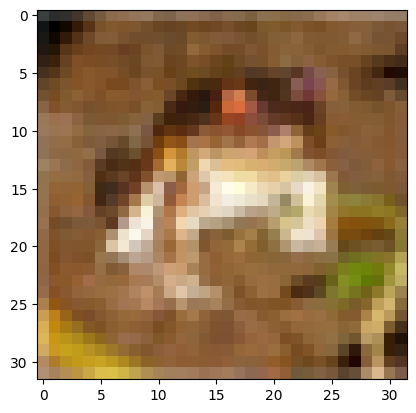

1/1 [==============================] - 0s 73ms/step


6

In [9]:
img_path = f'../data/images/{0+1:05d}.png'  
# Read and convert the image correctly using img_path
img_data = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
img_data_normalized = img_data / 255.0
plt.imshow(img_data_normalized)
plt.show() 
# predict by model_i
model_I(img_data)

# Model 2: Label Correction

In [10]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...
np.random.seed(5243_3)
label_correction_model =Sequential(
        [
            InputLayer(input_shape=(32, 32, 3)),
            Conv2D(filters=32, kernel_size=3, activation='relu'),
            MaxPool2D(pool_size=(2, 2), padding='same'),
            Dropout(0.3),
            Conv2D(filters=64, kernel_size=3, activation='relu'),
            BatchNormalization(momentum=0.9),
            MaxPool2D(pool_size=(2, 2), padding='same'),
            Dropout(0.3),
            Conv2D(filters=128, kernel_size=3, activation='relu'),
            MaxPool2D(pool_size=(2, 2), padding='same'),
            Dropout(0.3),
            Conv2D(filters=256, kernel_size=3, activation='relu'),
            BatchNormalization(momentum=0.9),
            Flatten(),
            Dropout(0.3),
            Dense(64, activation = 'relu'),
            Dropout(0.3),
            Dense(10, activation = 'softmax')
        ])
filepath='lcn_weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max')
callbacks_list_2 = [checkpoint]
label_correction_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

label_correction_model_history_callback = label_correction_model.fit(x_train_clean, y_train_clean, epochs=40, validation_data = (x_val_clean, y_val_clean), callbacks=callbacks_list_2)


Epoch 1/40
246/250 [============================>.] - ETA: 0s - loss: 2.5463 - accuracy: 0.2013
Epoch 1: val_accuracy improved from -inf to 0.28550, saving model to lcn_weights.best.hdf5
250/250 [==============================] - 4s 14ms/step - loss: 2.5368 - accuracy: 0.2038 - val_loss: 1.9568 - val_accuracy: 0.2855
Epoch 2/40
248/250 [============================>.] - ETA: 0s - loss: 2.0330 - accuracy: 0.2955
Epoch 2: val_accuracy improved from 0.28550 to 0.35650, saving model to lcn_weights.best.hdf5
250/250 [==============================] - 3s 12ms/step - loss: 2.0330 - accuracy: 0.2955 - val_loss: 1.8211 - val_accuracy: 0.3565
Epoch 3/40
248/250 [============================>.] - ETA: 0s - loss: 1.8508 - accuracy: 0.3477
Epoch 3: val_accuracy did not improve from 0.35650
250/250 [==============================] - 3s 12ms/step - loss: 1.8502 - accuracy: 0.3475 - val_loss: 1.7713 - val_accuracy: 0.3460
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 1.7328 - a

In [11]:
label_correction_model =Sequential(
        [
            InputLayer(input_shape=(32, 32, 3)),
            Conv2D(filters=32, kernel_size=3, activation='relu'),
            MaxPool2D(pool_size=(2, 2), padding='same'),
            Dropout(0.3),
            Conv2D(filters=64, kernel_size=3, activation='relu'),
            BatchNormalization(momentum=0.9),
            MaxPool2D(pool_size=(2, 2), padding='same'),
            Dropout(0.3),
            Conv2D(filters=128, kernel_size=3, activation='relu'),
            MaxPool2D(pool_size=(2, 2), padding='same'),
            Dropout(0.3),
            Conv2D(filters=256, kernel_size=3, activation='relu'),
            BatchNormalization(momentum=0.9),
            Flatten(),
            Dropout(0.3),
            Dense(64, activation = 'relu'),
            Dropout(0.3),
            Dense(10, activation = 'softmax')
        ])
label_correction_model.load_weights('lcn_weights.best.hdf5') 
label_correction_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
label_correction_model.evaluate(x_val_clean, y_val_clean)

63/63 [==============================] - 0s 5ms/step - loss: 1.4001 - accuracy: 0.5410


[1.400068759918213, 0.5410000085830688]

In [13]:
cleansed_y_labels = label_correction_model.predict(x_noisy)
cleansed_y_labels = np.array([np.argmax(i) for i in cleansed_y_labels])

1250/1250 [==============================] - 3s 2ms/step


# Model 2 - VGG16

In [14]:
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input

from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, concatenate
from keras.models import Sequential, Model
from keras.layers import Layer
from random import randint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import time
import psutil


In [15]:
def plot_training_history(history):
 
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot training & validation loss values
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].title.set_text('Model Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Training', 'Validation'], loc='best')
    
    # Plot training & validation accuracy values
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].title.set_text('Model Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(['Training', 'Validation'], loc='best')
    
    plt.tight_layout()
    plt.show()

Epoch 1/10


2024-03-20 17:40:09.545703: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


282/282 [==============================] - 15s 45ms/step - loss: 1.2587 - accuracy: 0.5546 - val_loss: 1.0237 - val_accuracy: 0.6268
Epoch 2/10
282/282 [==============================] - 12s 44ms/step - loss: 0.8615 - accuracy: 0.6823 - val_loss: 0.9463 - val_accuracy: 0.6660
Epoch 3/10
282/282 [==============================] - 13s 45ms/step - loss: 0.7601 - accuracy: 0.7177 - val_loss: 1.1580 - val_accuracy: 0.6123
Epoch 4/10
282/282 [==============================] - 13s 46ms/step - loss: 0.7126 - accuracy: 0.7340 - val_loss: 0.8345 - val_accuracy: 0.6965
Epoch 5/10
282/282 [==============================] - 13s 46ms/step - loss: 0.6630 - accuracy: 0.7535 - val_loss: 0.8621 - val_accuracy: 0.6858
Epoch 6/10
282/282 [==============================] - 13s 48ms/step - loss: 0.6148 - accuracy: 0.7675 - val_loss: 0.7905 - val_accuracy: 0.7148
Epoch 7/10
282/282 [==============================] - 13s 48ms/step - loss: 0.5856 - accuracy: 0.7782 - val_loss: 0.7874 - val_accuracy: 0.7113
Epo

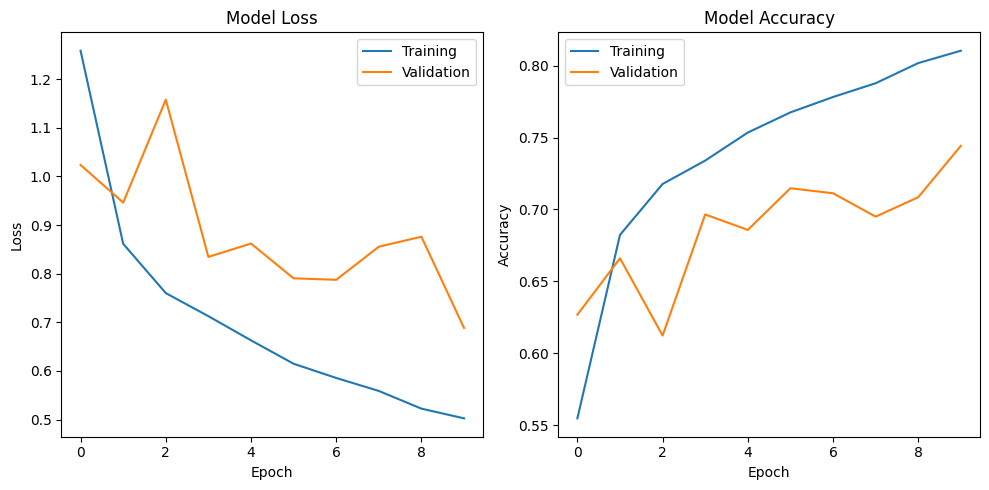

In [16]:
sgd=optimizers.SGD(learning_rate=0.001, momentum=0.9)
temp_model=VGG16(weights='imagenet',pooling="avg",include_top=False,input_shape=(32,32,3))
temp_model.compile(optimizer=sgd,
          loss="categorical_crossentropy",
          metrics=["accuracy"])
base_out=temp_model.output
top_fc1=BatchNormalization(name="hidden1")(base_out)
top_fc2=Flatten(name="flatten")(top_fc1)
top_fc3=Dense(128,activation="relu",name="hidden2")(top_fc2)
top_fc4=Dropout(0.4)(top_fc3)
top_fc5=Dense(10,activation="softmax",name="predictions")(top_fc4)
model_itr1 = tf.keras.Model(inputs=temp_model.input, outputs=top_fc5)
model_itr1.compile(optimizer=sgd,
          loss="categorical_crossentropy",
          metrics=["accuracy"])

cleansed_y_labels_one_hot = to_categorical(cleansed_y_labels, num_classes=10)
history1=model_itr1.fit(x_noisy,cleansed_y_labels_one_hot,epochs=10,verbose=1,validation_split=0.1,batch_size=128)
# Save the model as the first iteration
model_itr1.save('vgg16_first_iteration.h5')
plot_training_history(history1)

In [17]:
x_clean_itr2 = x_clean[:8000]
x_clean_finaltest = x_clean[8000:]

y_clean_itr2 = y_clean[:8000]
y_clean_finaltest = y_clean[8000:]
y_clean_itr2_one_hot = to_categorical(y_clean_itr2, num_classes=10)
y_clean_finaltest_one_hot = to_categorical(y_clean_finaltest, num_classes=10)

Epoch 1/20


2024-03-20 17:42:22.718510: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


57/57 [==============================] - 3s 50ms/step - loss: 1.2481 - accuracy: 0.6100 - val_loss: 2.0903 - val_accuracy: 0.4125
Epoch 2/20
57/57 [==============================] - 3s 47ms/step - loss: 0.9426 - accuracy: 0.6721 - val_loss: 1.2325 - val_accuracy: 0.5900
Epoch 3/20
57/57 [==============================] - 3s 50ms/step - loss: 0.8280 - accuracy: 0.7142 - val_loss: 1.4815 - val_accuracy: 0.4988
Epoch 4/20
57/57 [==============================] - 3s 50ms/step - loss: 0.7372 - accuracy: 0.7458 - val_loss: 1.1058 - val_accuracy: 0.5987
Epoch 5/20
57/57 [==============================] - 3s 49ms/step - loss: 0.6586 - accuracy: 0.7707 - val_loss: 1.4110 - val_accuracy: 0.5188
Epoch 6/20
57/57 [==============================] - 3s 47ms/step - loss: 0.5914 - accuracy: 0.8014 - val_loss: 1.0077 - val_accuracy: 0.6513
Epoch 7/20
57/57 [==============================] - 3s 49ms/step - loss: 0.5226 - accuracy: 0.8279 - val_loss: 1.1054 - val_accuracy: 0.6025
Epoch 8/20
57/57 [======

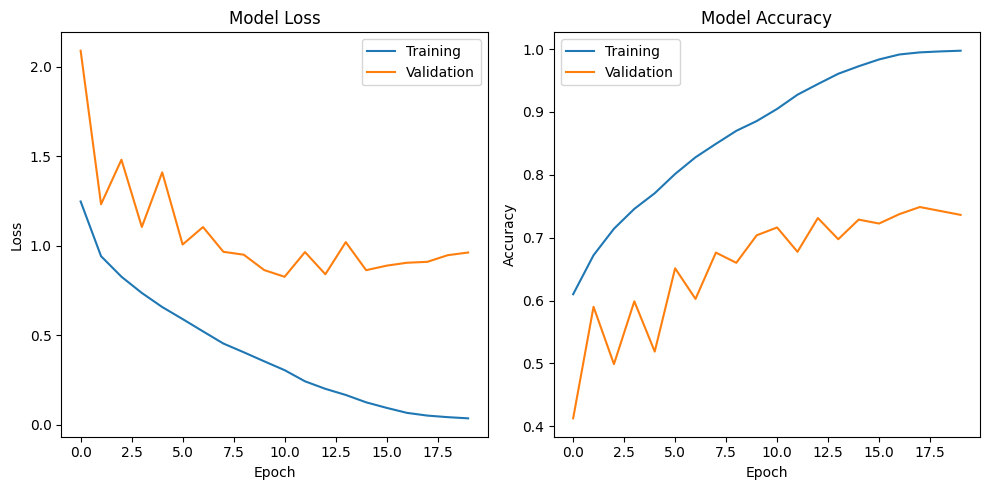

In [18]:
# Load the previously trained model
model_itr2 = load_model('vgg16_first_iteration.h5')
# Continue training with new data
history2 = model_itr2.fit(x_clean_itr2, y_clean_itr2_one_hot, epochs=20, verbose=1,validation_split=0.1, batch_size=128)
# Save the model again if you plan to continue training further
model_itr2.save('vgg16_second_iteration.h5')
plot_training_history(history2)

## Model 2: VGG16 + SVM

In [20]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Load the VGG16 model pre-trained on ImageNet without the top layer
base_model = load_model('vgg16_second_iteration.h5')

# This model will output the features
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output) #base_out


In [21]:
# Assuming x_noisy is your dataset
features = feature_extractor.predict(x_noisy)

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# It's often a good idea to scale features before using them in an SVM
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Splitting the dataset for training and testing
#X_train, X_test, y_train, y_test = train_test_split(features_scaled, cleansed_y_labels, test_size=0.2, random_state=42)

svm_classifier = SVC(kernel='linear')  # You can experiment with different kernels
svm_classifier.fit(features_scaled,cleansed_y_labels) #(X_train, y_train)

from joblib import dump, load
dump(svm_classifier, 'svm_classifier.joblib')


1250/1250 [==============================] - 4s 3ms/step


['svm_classifier.joblib']

In [22]:
svm_classifier_2 = load('svm_classifier.joblib')
features_2 = feature_extractor.predict(x_clean_itr2)
scaler = StandardScaler()
features_scaled_2 = scaler.fit_transform(features_2)
svm_classifier_2.fit(features_scaled_2, y_clean_itr2)


250/250 [==============================] - 1s 4ms/step


SVC(kernel='linear')

In [23]:
features_finaltest = feature_extractor.predict(x_clean_finaltest)
scaler = StandardScaler()
features_scaled_final = scaler.fit_transform(features_finaltest)

y_pred = svm_classifier_2.predict(features_scaled_final)
print("SVM Accuracy:", accuracy_score(y_clean_finaltest, y_pred))


63/63 [==============================] - 0s 4ms/step
SVM Accuracy: 0.759


In [24]:
# Concatenate the arrays along axis 0 (row-wise)
concatenated_array = np.concatenate((y_clean[8000:], y_pred), axis=0)

df = pd.DataFrame({
    'y_clean': y_clean[8000:],
    'y_pred': y_pred
})

df['correct'] = np.where(df['y_clean'] == df['y_pred'], 1, 0)
df.to_csv('VGG_SVM_pred1w.csv', index=False)

# Model II function

In [26]:
def model_II(img_data):
    img_data_normalized = img_data.reshape(1,32,32,3) / 255.0
    # Load the VGG16 model pre-trained on ImageNet without the top layer
    base_model = load_model('vgg16_second_iteration.h5')
    # This model will output the features
    feature_extractor = Model(inputs=base_model.input, outputs=base_model.output) 
    features = feature_extractor.predict(img_data_normalized)
    # It's often a good idea to scale features before using them in an SVM
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    y_pred = svm_classifier.predict(features_scaled)
    return np.argmax(y_pred)

In [27]:
img_path = f'../data/images/{0+1:05d}.png'  
# Read and convert the image correctly using img_path
img_data = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
img_data_normalized = img_data / 255.0

model_II(img_data)

1/1 [==============================] - 0s 85ms/step


0

In [28]:
'''
def model_II(image):
    # This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    img = np.reshape(image, (1, 32, 32, 3))/255
    #img=image.reshape(1,32,32,3)/255.0
    model_vgg = load_model('vgg16_second_iteration.h5')
    prediction=model_vgg.predict(img)
    return np.argmax(prediction)
'''

"\ndef model_II(image):\n    # This function should takes in the image of dimension 32*32*3 as input and returns a label prediction\n    img = np.reshape(image, (1, 32, 32, 3))/255\n    #img=image.reshape(1,32,32,3)/255.0\n    model_vgg = load_model('vgg16_second_iteration.h5')\n    prediction=model_vgg.predict(img)\n    return np.argmax(prediction)\n"

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [1]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.